# New Training

## Table of Contents
* [Data Preperation](#chapter1)
* [Data Visualisation](#chapter2)
* [Model Training](#chapter3)
    * [Testing Model Archetecture](#section_3_1)
    * [Model Setup for fine tuning](#section_3_2)
    * [MobileNetV2 fine tuning](#section_3_3)
    * [MobileNetV3 large fine tuning](#section_3_4)
    * [MobileNetV2 feature extraction 5 epochs](#section_3_5)
    * [MobileNetV2 feature extraction 25 epochs](#section_3_6)

## Data Preparation <a class="anchor" id="chapter1"></a>

In [1]:
import cv2
import os

def extract_frames_from_video(video_path, output_folder, frame_rate=1):
    """
    Extract frames from a video and save them as images.
    
    :param video_path: Path to the input video file.
    :param output_folder: Directory where extracted images will be saved.
    :param frame_rate: Number of frames to skip before extracting the next one.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    count = 0
    frame_id = 0
    
    while success:
        if count % frame_rate == 0:
            image_filename = os.path.join(output_folder, f"frame_{frame_id}.jpg")
            cv2.imwrite(image_filename, image)
            frame_id += 1
        success, image = vidcap.read()
        count += 1
    
    vidcap.release()


In [3]:
import glob

dataset_folder = 'dataset'  # Folder containing class subfolders with videos
output_dataset_folder = 'processed_dataset'  # Where extracted frames will be stored

classes = os.listdir(dataset_folder)

for class_name in classes:
    class_videos = glob.glob(os.path.join(dataset_folder, class_name, '*.mp4'))  # Adjust extension if needed
    for video_path in class_videos:
        video_basename = os.path.basename(video_path).split('.')[0]
        output_folder = os.path.join(output_dataset_folder, class_name, video_basename)
        extract_frames_from_video(video_path, output_folder, frame_rate=10)  # Extract every 10th frame

In [4]:
from sklearn.model_selection import train_test_split

train_videos = {}
val_videos = {}

for class_name in classes:
    video_folders = os.listdir(os.path.join(output_dataset_folder, class_name))
    train_vids, val_vids = train_test_split(video_folders, test_size=0.3, random_state=42)
    train_videos[class_name] = train_vids
    val_videos[class_name] = val_vids

In [7]:
import shutil
import os

def move_frames(video_list, source_folder, dest_folder):
    for class_name, videos in video_list.items():
        dest_class_folder = os.path.join(dest_folder, class_name)
        if not os.path.exists(dest_class_folder):
            os.makedirs(dest_class_folder)
        
        for video_name in videos:
            source_path = os.path.join(source_folder, class_name, video_name)
            
            # List all frame files in the video folder
            frame_files = os.listdir(source_path)
            
            for frame_file in frame_files:
                # Create a unique filename by incorporating the video name
                new_filename = f"{video_name}_{frame_file}"
                source_file = os.path.join(source_path, frame_file)
                dest_file = os.path.join(dest_class_folder, new_filename)
                
                # Move and rename the frame file
                shutil.move(source_file, dest_file)



In [8]:
train_folder = 'processed_dataset/train'
val_folder = 'processed_dataset/val'

move_frames(train_videos, output_dataset_folder, train_folder)
move_frames(val_videos, output_dataset_folder, val_folder)


In [9]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms


data_dir = 'processed_dataset'

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    'train': ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
    'val': ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val']),
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4),
}

class_names = image_datasets['train'].classes


## Data visualiztion <a class="anchor" id="chapter2"></a>

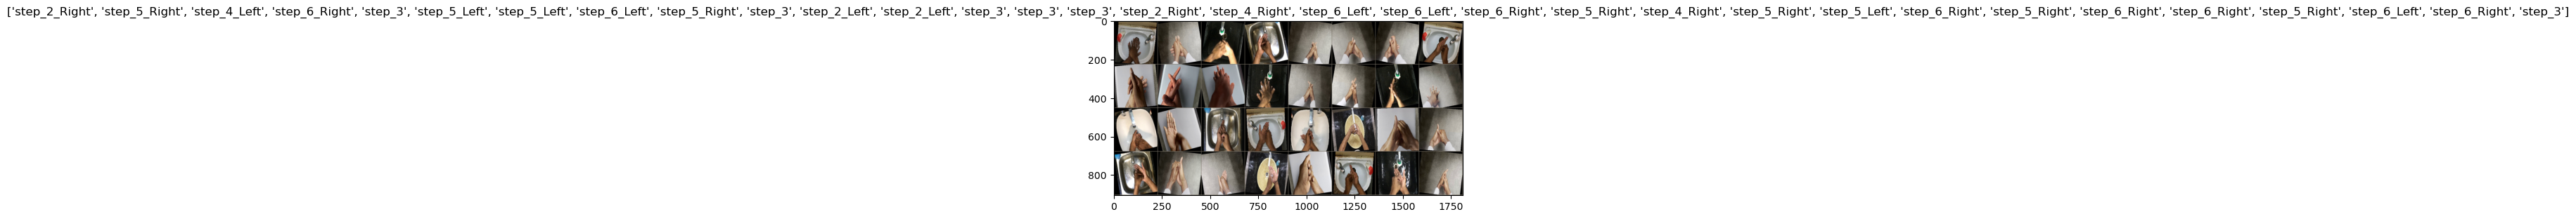

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Model Training <a class="anchor" id="chapter3"></a>
### 1. Testing model architecture <a id="section_3_1"></a>

In [23]:
import os
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights


# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Data directories
data_dir = 'processed_dataset'  # Path to your dataset

# Number of classes (adjust according to your dataset)
num_classes = 10  # Since you have 10 steps

# Batch size and number of epochs
batch_size = 32
num_epochs = 25

# Data transformations
input_size = 224  # MobileNetV2 default input size

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Create datasets
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val']),
}

# Create dataloaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4),
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(f'Classes: {class_names}')

# Load the pretrained MobileNetV2 model
#model = models.mobilenet_v2(weights=True)

# Load the weights
weights_path = "./model/weights/mobilenet_v2-b0353104.pth"

weights = MobileNet_V2_Weights.DEFAULT
model = mobilenet_v2()
state_dict = torch.load(weights_path)
model.load_state_dict(state_dict)

# Modify the last layer to match the number of classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Move model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Only train parameters that are not frozen
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler (optional)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store loss and accuracy history
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print('-' * 20)
        print(f'Epoch {epoch +1}/{num_epochs}')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data batches
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                # Track history only in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Step the scheduler after each epoch in training phase
            if phase == 'train':
                scheduler.step()

            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it has better accuracy
            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            else:
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)

    time_elapsed = time.time() - since
    print('-' * 20)
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed %60:.0f}s')
    print(f'Best validation Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

# Train the model
model, train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

# Save the model
torch.save(model.state_dict(), 'mobilenetv2_handwash.pth')

Using device: cpu
Classes: ['step_1', 'step_2_Left', 'step_2_Right', 'step_3', 'step_4_Left', 'step_4_Right', 'step_5_Left', 'step_5_Right', 'step_6_Left', 'step_6_Right']
--------------------
Epoch 1/25
Train Loss: 0.5250 Acc: 0.7955
Val Loss: 0.2261 Acc: 0.9217
--------------------
Epoch 2/25
Train Loss: 0.2227 Acc: 0.9243
Val Loss: 0.1611 Acc: 0.9485
--------------------
Epoch 3/25
Train Loss: 0.1562 Acc: 0.9479
Val Loss: 0.1921 Acc: 0.9403
--------------------
Epoch 4/25
Train Loss: 0.1399 Acc: 0.9564
Val Loss: 0.1959 Acc: 0.9362
--------------------
Epoch 5/25
Train Loss: 0.1091 Acc: 0.9649
Val Loss: 0.1401 Acc: 0.9562
--------------------
Epoch 6/25


KeyboardInterrupt: 

In [ ]:
# Plot training and validation loss and accuracy
import matplotlib.pyplot as plt

# Plot loss
plt.figure()
plt.plot(range(1, num_epochs+1), train_loss_history, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_loss_history, label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# Plot accuracy
plt.figure()
plt.plot(range(1, num_epochs+1), train_acc_history, label='Train Acc')
plt.plot(range(1, num_epochs+1), val_acc_history, label='Val Acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

### 2. Model setup for fine tuning <a class="anchor" id="section_2_2"></a>

In [2]:
# Import statements
import os
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [3]:
# Data directories
data_dir = 'processed_dataset'  # Path to your dataset

# Number of classes
num_classes = 10  # Since you have 10 steps

# Batch size and number of epochs
batch_size = 32
num_epochs = 5

# Input size (depends on the model, but 224x224 is standard for MobileNet)
input_size = 224

In [4]:
# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Create datasets
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val']),
}

# Create dataloaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4),
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(f'Classes: {class_names}')

Classes: ['step_1', 'step_2_Left', 'step_2_Right', 'step_3', 'step_4_Left', 'step_4_Right', 'step_5_Left', 'step_5_Right', 'step_6_Left', 'step_6_Right']


In [5]:
# Function to set the requires_grad attribute of the parameters
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Function to initialize the model
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    if model_name == "mobilenet_v2":
        #model = models.mobilenet_v2(weights=use_pretrained)
        model = models.mobilenet_v2()
        # Load the weights
        weights_path = "./model/weights/mobilenet_v2-7ebf99e0.pth"
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)

        set_parameter_requires_grad(model, feature_extract)
        # Change the final layer
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "mobilenet_v3_large":
        #model = models.mobilenet_v3_large(weights=use_pretrained)
        model = models.mobilenet_v3_large()
        # Load the weights
        weights_path = "./model/weights/mobilenet_v3_large-5c1a4163.pth"
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
        set_parameter_requires_grad(model, feature_extract)
        # Change the final layer
        num_ftrs = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()

    return model, input_size

### 3. MobileNetv2 fine tuning <a id="section_2_3"></a>

In [6]:
# Specify the model to use
model_name = "mobilenet_v2"  # Change to "mobilenet_v3_large" to use MobileNetV3
feature_extract = False  # Set to True for feature extraction, False for fine-tuning

# Initialize the model
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Update the data_transforms to match the input size of the model
data_transforms['train'].transforms[0] = transforms.Resize((input_size, input_size))
data_transforms['val'].transforms[0] = transforms.Resize((input_size, input_size))

# Move model to device
model_ft = model_ft.to(device)

# Print model architecture
print(model_ft)

# Gather the parameters to be optimized/updated in this run
params_to_update = model_ft.parameters()
print("Params to learn:")

if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad:
            print("\t", name)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

C:\Users\msila\AppData\Local\Temp\ipykernel_9436\2800303043.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path)


In [16]:
# Define optimizer and criterion
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(params_to_update, lr=0.001)

# Learning rate scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Training function with TemporaryDirectory
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Lists to store loss and accuracy history
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0

        for epoch in range(num_epochs):
            print('-' * 20)
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 20)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluation mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data batches
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    # Track history only in training phase
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward pass and optimization in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                # Step the scheduler after each epoch in training phase
                if phase == 'train':
                    scheduler.step()

                # Calculate epoch loss and accuracy
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Deep copy the model if it has better accuracy
                if phase == 'val':
                    val_loss_history.append(epoch_loss)
                    val_acc_history.append(epoch_acc.item())
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(model.state_dict())
                        # Save the best model weights
                        torch.save(model.state_dict(), os.path.join(tempdir, 'best_model_weights.pth'))
                else:
                    train_loss_history.append(epoch_loss)
                    train_acc_history.append(epoch_acc.item())

            print()

        time_elapsed = time.time() - since
        print('-' * 20)
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed %60:.0f}s')
        print(f'Best validation Acc: {best_acc:.4f}')

        # Load best model weights
        model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Train the model
model_ft, train_loss, val_loss, train_acc, val_acc = train_model(
    model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

# Save the trained model
torch.save(model_ft.state_dict(), f'{model_name}_handwash.pth')

--------------------
Epoch 1/5
--------------------
Train Loss: 0.4012 Acc: 0.8545
Val Loss: 0.1315 Acc: 0.9562

--------------------
Epoch 2/5
--------------------
Train Loss: 0.1370 Acc: 0.9553
Val Loss: 0.0952 Acc: 0.9701

--------------------
Epoch 3/5
--------------------
Train Loss: 0.0892 Acc: 0.9705
Val Loss: 0.1235 Acc: 0.9600

--------------------
Epoch 4/5
--------------------
Train Loss: 0.0875 Acc: 0.9712
Val Loss: 0.1860 Acc: 0.9562

--------------------
Epoch 5/5
--------------------
Train Loss: 0.0702 Acc: 0.9777
Val Loss: 0.0732 Acc: 0.9797

--------------------
Training complete in 78m 27s
Best validation Acc: 0.9797


In [ ]:
# Function to visualize model predictions
def visualize_model(model, dataloaders, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size()[0]):
                images_so_far += 1
                plt.figure(figsize=(5, 5))
                imshow(inputs.cpu().data[i], title=f'Predicted: {class_names[preds[i]]}')
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Helper function to show an image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize some predictions
visualize_model(model_ft, dataloaders)

In [ ]:
# Function to plot training history
def plot_training_history(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, num_epochs+1)
    # Plot Loss
    plt.figure()
    plt.plot(epochs, train_loss, 'r-', label='Training loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure()
    plt.plot(epochs, train_acc, 'r-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the training history
plot_training_history(train_loss, val_loss, train_acc, val_acc)

### 4. Mobilenetv3 Large fine tuning <a id="section_2_4"></a>

In [7]:
# Import statements
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Data directories
data_dir = 'processed_dataset'  # Path to your dataset

# Number of classes
num_classes = 10  # Since you have 10 steps

# Batch size and number of epochs
batch_size = 32
num_epochs = 5

# Input size (depends on the model, but 224x224 is standard for MobileNet)
input_size = 224

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Create datasets
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val']),
}

# Create dataloaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4),
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(f'Classes: {class_names}')

# Function to set the requires_grad attribute of the parameters
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Function to initialize the model
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    if model_name == "mobilenet_v2":
        #model = models.mobilenet_v2(weights=use_pretrained)
        model = models.mobilenet_v2()
        # Load the weights
        weights_path = "./model/weights/mobilenet_v2-7ebf99e0.pth"
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)

        set_parameter_requires_grad(model, feature_extract)
        # Change the final layer
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "mobilenet_v3_large":
        #model = models.mobilenet_v3_large(weights=use_pretrained)
        model = models.mobilenet_v3_large()
        # Load the weights
        weights_path = "./model/weights/mobilenet_v3_large-5c1a4163.pth"
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
        set_parameter_requires_grad(model, feature_extract)
        # Change the final layer
        num_ftrs = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()

    return model, input_size

# Specify the model to use
model_name = "mobilenet_v3_large" 
feature_extract = False  # Set to True for feature extraction, False for fine-tuning

# Initialize the model
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Update the data_transforms to match the input size of the model
data_transforms['train'].transforms[0] = transforms.Resize((input_size, input_size))
data_transforms['val'].transforms[0] = transforms.Resize((input_size, input_size))

# Move model to device
model_ft = model_ft.to(device)

# Print model architecture
print(model_ft)

# Gather the parameters to be optimized/updated in this run
params_to_update = model_ft.parameters()
print("Params to learn:")

if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad:
            print("\t", name)

# Define optimizer and criterion
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(params_to_update, lr=0.001)

# Learning rate scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Training function with TemporaryDirectory
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Lists to store loss and accuracy history
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0

        for epoch in range(num_epochs):
            print('-' * 20)
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 20)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluation mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data batches
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    # Track history only in training phase
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward pass and optimization in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                # Step the scheduler after each epoch in training phase
                if phase == 'train':
                    scheduler.step()

                # Calculate epoch loss and accuracy
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Deep copy the model if it has better accuracy
                if phase == 'val':
                    val_loss_history.append(epoch_loss)
                    val_acc_history.append(epoch_acc.item())
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(model.state_dict())
                        # Save the best model weights
                        torch.save(model.state_dict(), os.path.join(tempdir, 'best_model_weights.pth'))
                else:
                    train_loss_history.append(epoch_loss)
                    train_acc_history.append(epoch_acc.item())

            print()

        time_elapsed = time.time() - since
        print('-' * 20)
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed %60:.0f}s')
        print(f'Best validation Acc: {best_acc:.4f}')

        # Load best model weights
        model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Train the model
model_ft, train_loss, val_loss, train_acc, val_acc = train_model(
    model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

# Save the trained model
torch.save(model_ft.state_dict(), f'{model_name}_handwash.pth')

Using device: cpu
Classes: ['step_1', 'step_2_Left', 'step_2_Right', 'step_3', 'step_4_Left', 'step_4_Right', 'step_5_Left', 'step_5_Right', 'step_6_Left', 'step_6_Right']
MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        

C:\Users\msila\AppData\Local\Temp\ipykernel_9436\2279132342.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path)


--------------------
Epoch 1/5
--------------------
Train Loss: 0.3819 Acc: 0.8624
Val Loss: 0.2939 Acc: 0.8969

--------------------
Epoch 2/5
--------------------
Train Loss: 0.1152 Acc: 0.9629
Val Loss: 0.1736 Acc: 0.9470

--------------------
Epoch 3/5
--------------------
Train Loss: 0.0894 Acc: 0.9724
Val Loss: 0.1527 Acc: 0.9531

--------------------
Epoch 4/5
--------------------
Train Loss: 0.0633 Acc: 0.9782
Val Loss: 0.0593 Acc: 0.9820

--------------------
Epoch 5/5
--------------------
Train Loss: 0.0720 Acc: 0.9776
Val Loss: 0.1388 Acc: 0.9624

--------------------
Training complete in 58m 4s
Best validation Acc: 0.9820


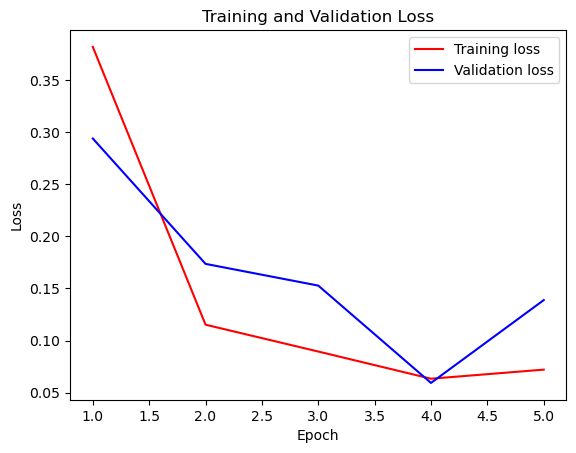

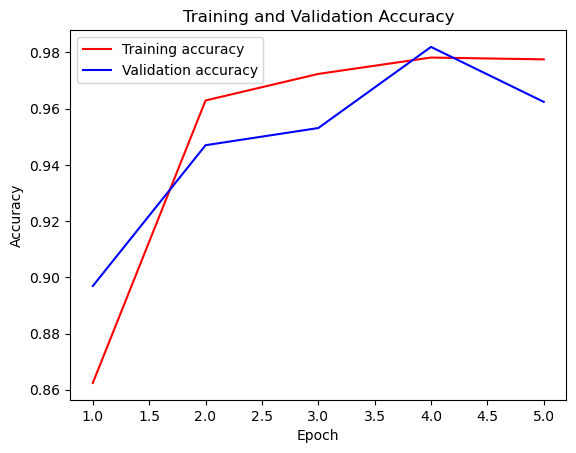

In [8]:
# Function to plot training history
def plot_training_history(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, num_epochs+1)
    # Plot Loss
    plt.figure()
    plt.plot(epochs, train_loss, 'r-', label='Training loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure()
    plt.plot(epochs, train_acc, 'r-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the training history
plot_training_history(train_loss, val_loss, train_acc, val_acc)

### 5. MobileNetV2 Feature Extraction 5 epoch <a id="section_2_5"></a>

In [9]:
# Import statements
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Data directories
data_dir = 'processed_dataset'  # Path to your dataset

# Number of classes
num_classes = 10  # Since you have 10 steps

# Batch size and number of epochs
batch_size = 32
num_epochs = 5

# Input size (depends on the model, but 224x224 is standard for MobileNet)
input_size = 224

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Create datasets
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val']),
}

# Create dataloaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4),
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(f'Classes: {class_names}')

# Function to set the requires_grad attribute of the parameters
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Function to initialize the model
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    if model_name == "mobilenet_v2":
        #model = models.mobilenet_v2(weights=use_pretrained)
        model = models.mobilenet_v2()
        # Load the weights
        weights_path = "./model/weights/mobilenet_v2-7ebf99e0.pth"
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)

        set_parameter_requires_grad(model, feature_extract)
        # Change the final layer
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "mobilenet_v3_large":
        #model = models.mobilenet_v3_large(weights=use_pretrained)
        model = models.mobilenet_v3_large()
        # Load the weights
        weights_path = "./model/weights/mobilenet_v3_large-5c1a4163.pth"
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
        set_parameter_requires_grad(model, feature_extract)
        # Change the final layer
        num_ftrs = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()

    return model, input_size

# Specify the model to use
model_name = "mobilenet_v2" 
feature_extract = True  # Set to True for feature extraction, False for fine-tuning

# Initialize the model
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Update the data_transforms to match the input size of the model
data_transforms['train'].transforms[0] = transforms.Resize((input_size, input_size))
data_transforms['val'].transforms[0] = transforms.Resize((input_size, input_size))

# Move model to device
model_ft = model_ft.to(device)

# Print model architecture
print(model_ft)

# Gather the parameters to be optimized/updated in this run
params_to_update = model_ft.parameters()
print("Params to learn:")

if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad:
            print("\t", name)

# Define optimizer and criterion
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(params_to_update, lr=0.001)

# Learning rate scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Training function with TemporaryDirectory
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Lists to store loss and accuracy history
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0

        for epoch in range(num_epochs):
            print('-' * 20)
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 20)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluation mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data batches
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    # Track history only in training phase
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward pass and optimization in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                # Step the scheduler after each epoch in training phase
                if phase == 'train':
                    scheduler.step()

                # Calculate epoch loss and accuracy
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Deep copy the model if it has better accuracy
                if phase == 'val':
                    val_loss_history.append(epoch_loss)
                    val_acc_history.append(epoch_acc.item())
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(model.state_dict())
                        # Save the best model weights
                        torch.save(model.state_dict(), os.path.join(tempdir, 'best_model_weights.pth'))
                else:
                    train_loss_history.append(epoch_loss)
                    train_acc_history.append(epoch_acc.item())

            print()

        time_elapsed = time.time() - since
        print('-' * 20)
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed %60:.0f}s')
        print(f'Best validation Acc: {best_acc:.4f}')

        # Load best model weights
        model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Train the model
model_ft, train_loss, val_loss, train_acc, val_acc = train_model(
    model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

# Save the trained model
torch.save(model_ft.state_dict(), f'{model_name}_fe_handwash.pth')

Using device: cpu
Classes: ['step_1', 'step_2_Left', 'step_2_Right', 'step_3', 'step_4_Left', 'step_4_Right', 'step_5_Left', 'step_5_Right', 'step_6_Left', 'step_6_Right']


C:\Users\msila\AppData\Local\Temp\ipykernel_9436\2612548617.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

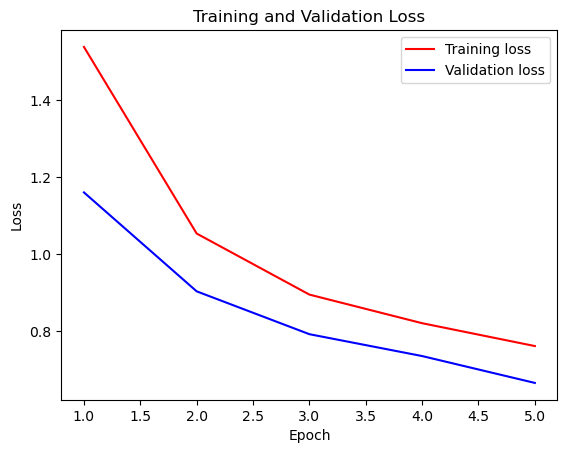

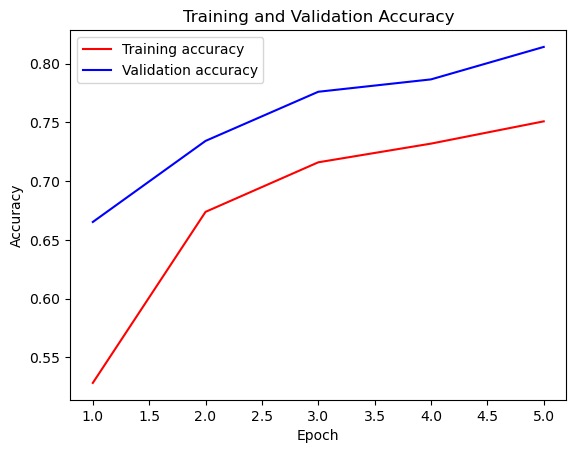

In [10]:
plot_training_history(train_loss, val_loss, train_acc, val_acc)

### 6. MobileNetV2 Feature Extraction 25 epoch <a id="section_2_6"></a>

In [11]:
# Import statements
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Data directories
data_dir = 'processed_dataset'  # Path to your dataset

# Number of classes
num_classes = 10  # Since you have 10 steps

# Batch size and number of epochs
batch_size = 32
num_epochs = 25

# Input size (depends on the model, but 224x224 is standard for MobileNet)
input_size = 224

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Create datasets
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val']),
}

# Create dataloaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4),
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(f'Classes: {class_names}')

# Function to set the requires_grad attribute of the parameters
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Function to initialize the model
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    if model_name == "mobilenet_v2":
        #model = models.mobilenet_v2(weights=use_pretrained)
        model = models.mobilenet_v2()
        # Load the weights
        weights_path = "./model/weights/mobilenet_v2-7ebf99e0.pth"
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)

        set_parameter_requires_grad(model, feature_extract)
        # Change the final layer
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "mobilenet_v3_large":
        #model = models.mobilenet_v3_large(weights=use_pretrained)
        model = models.mobilenet_v3_large()
        # Load the weights
        weights_path = "./model/weights/mobilenet_v3_large-5c1a4163.pth"
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
        set_parameter_requires_grad(model, feature_extract)
        # Change the final layer
        num_ftrs = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()

    return model, input_size

# Specify the model to use
model_name = "mobilenet_v2" 
feature_extract = True  # Set to True for feature extraction, False for fine-tuning

# Initialize the model
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Update the data_transforms to match the input size of the model
data_transforms['train'].transforms[0] = transforms.Resize((input_size, input_size))
data_transforms['val'].transforms[0] = transforms.Resize((input_size, input_size))

# Move model to device
model_ft = model_ft.to(device)

# Print model architecture
print(model_ft)

# Gather the parameters to be optimized/updated in this run
params_to_update = model_ft.parameters()
print("Params to learn:")

if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad:
            print("\t", name)

# Define optimizer and criterion
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(params_to_update, lr=0.001)

# Learning rate scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Training function with TemporaryDirectory
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Lists to store loss and accuracy history
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0

        for epoch in range(num_epochs):
            print('-' * 20)
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 20)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluation mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data batches
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    # Track history only in training phase
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward pass and optimization in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                # Step the scheduler after each epoch in training phase
                if phase == 'train':
                    scheduler.step()

                # Calculate epoch loss and accuracy
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Deep copy the model if it has better accuracy
                if phase == 'val':
                    val_loss_history.append(epoch_loss)
                    val_acc_history.append(epoch_acc.item())
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(model.state_dict())
                        # Save the best model weights
                        torch.save(model.state_dict(), os.path.join(tempdir, 'best_model_weights.pth'))
                else:
                    train_loss_history.append(epoch_loss)
                    train_acc_history.append(epoch_acc.item())

            print()

        time_elapsed = time.time() - since
        print('-' * 20)
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed %60:.0f}s')
        print(f'Best validation Acc: {best_acc:.4f}')

        # Load best model weights
        model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Train the model
model_ft, train_loss, val_loss, train_acc, val_acc = train_model(
    model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

# Save the trained model
torch.save(model_ft.state_dict(), f'{model_name}_fe_25_handwash.pth')

Using device: cpu
Classes: ['step_1', 'step_2_Left', 'step_2_Right', 'step_3', 'step_4_Left', 'step_4_Right', 'step_5_Left', 'step_5_Right', 'step_6_Left', 'step_6_Right']


C:\Users\msila\AppData\Local\Temp\ipykernel_9436\2915154467.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

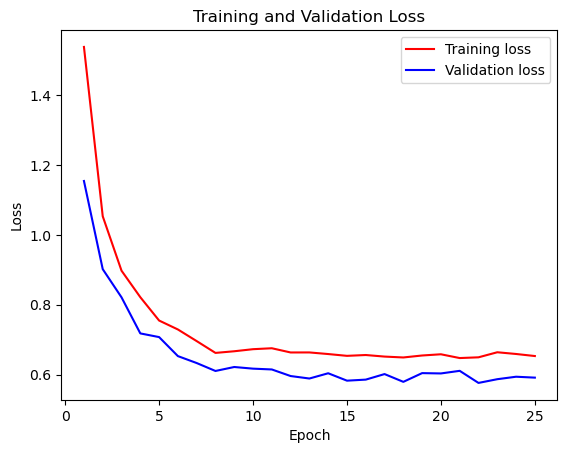

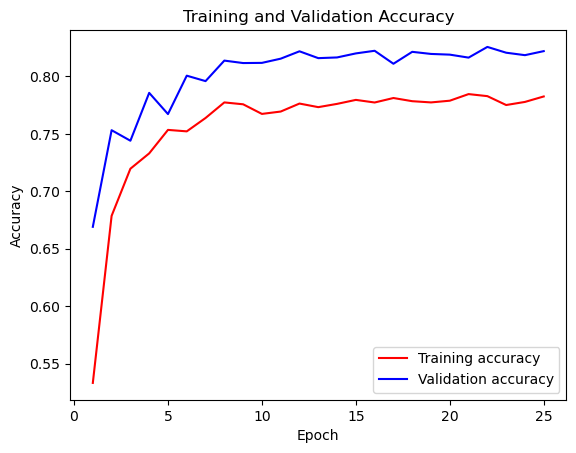

In [12]:
plot_training_history(train_loss, val_loss, train_acc, val_acc)